In [ ]:
import kagglehub
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

sns.set_style("whitegrid")
sns.set_palette("Set2")

In [ ]:
# ---------------------------------------------
# 1. Download dataset from Kaggle
# ---------------------------------------------
path = kagglehub.dataset_download("zaheenhamidani/ultimate-spotify-tracks-db")
print("Path to dataset files:", path)

# Most KaggleHub datasets include one or more CSVs -> let's find the right one
for file in os.listdir(path):
    print("Found file:", file)

# Load the main file (usually 'SpotifyFeatures.csv')
df = pd.read_csv(os.path.join(path, "SpotifyFeatures.csv"))
print("\nShape of the dataset:", df.shape)
print(df.head())

Using Colab cache for faster access to the 'ultimate-spotify-tracks-db' dataset.
Path to dataset files: /kaggle/input/ultimate-spotify-tracks-db
Found file: SpotifyFeatures.csv

Shape of the dataset: (232725, 18)
   genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950

In [ ]:
# ---------------------------------------------
# 2. Selection and sampling (1000 tracks)
# ---------------------------------------------
df_sample = df.sample(n=1000, random_state=0)
print("\nShape of the sampled dataset:", df_sample.shape)

# Selection of features of interest
features = [
    'genre', 'danceability', 'energy', 'speechiness', 'acousticness',
    'popularity', 'liveness', 'valence', 'duration_ms', 'mode'
]

X = df_sample[features].dropna()

# Binary conversion
# Ensure 'mode' is numeric before further processing
if X['mode'].dtype == 'object':
    X['mode'] = X['mode'].map({'Major': 1, 'Minor': 0}).astype(int)


# ---------------------------------------------
#  Separation by variable type
# ---------------------------------------------
categorical_features = ['genre']
binary_features = ['mode'] # 'mode' is now numeric (0 or 1)
numeric_features = [
    'danceability', 'energy', 'speechiness', 'acousticness',
    'popularity', 'liveness', 'valence', 'duration_ms'
]



# One-hot encoding for 'genre'
X_cat = pd.get_dummies(X[categorical_features], prefix=categorical_features)

# Standardization only for numeric features
scaler = StandardScaler()
# Combine numeric and binary features for scaling, as 'mode' is now numeric
features_to_scale = numeric_features + binary_features
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X[features_to_scale]),
    columns=features_to_scale
)

# Let's combine all parts: numeric + binary + categorical
# X_num_scaled now includes the scaled 'mode' column
X_final = pd.concat(
    [X_num_scaled.reset_index(drop=True),
     X_cat.reset_index(drop=True)],
    axis=1
)

# Create a new X DataFrame containing only the numeric and one-hot encoded features
X = pd.concat(
    [X[numeric_features + binary_features].reset_index(drop=True), # Use original numeric and binary features (now numeric)
     X_cat.reset_index(drop=True)],
    axis=1
)


print("\n✅ Dataset ready for clustering!")
print("Final shape:", X_final.shape)
print("First columns:", X_final.columns[:10].tolist())
print("\nShape of DataFrame X for visualizations:", X.shape)


# Standardized matrix (numpy) for K-Means
X_scaled = X_final.values


Shape of the sampled dataset: (1000, 18)

✅ Dataset ready for clustering!
Final shape: (1000, 36)
First columns: ['danceability', 'energy', 'speechiness', 'acousticness', 'popularity', 'liveness', 'valence', 'duration_ms', 'mode', 'genre_A Capella']

Shape of DataFrame X for visualizations: (1000, 36)


📊 Distribution of audio features before clustering:



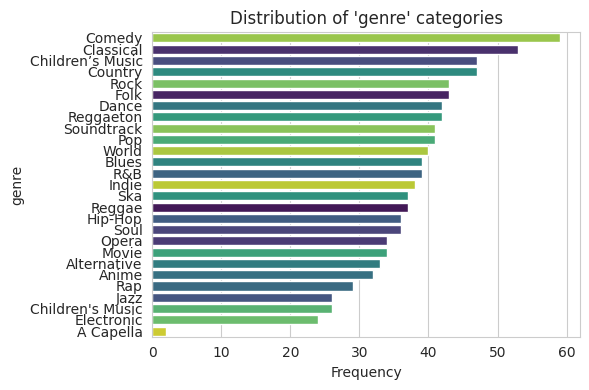

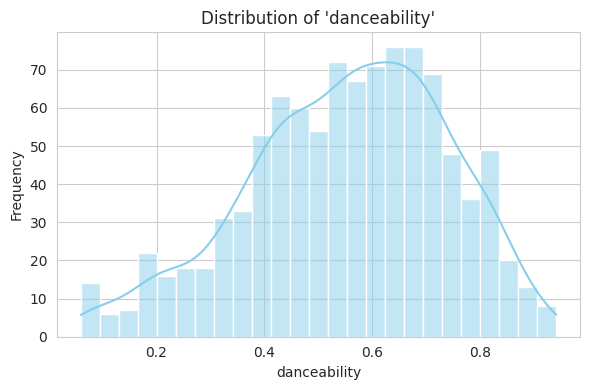

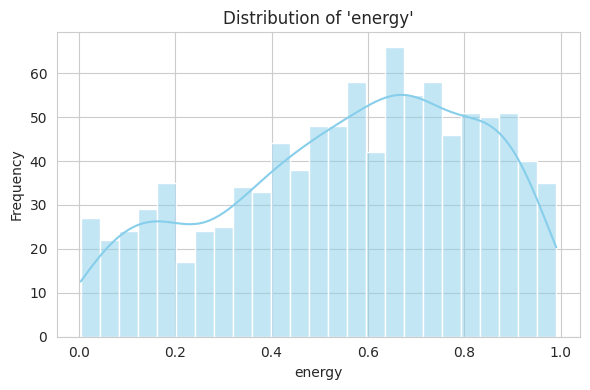

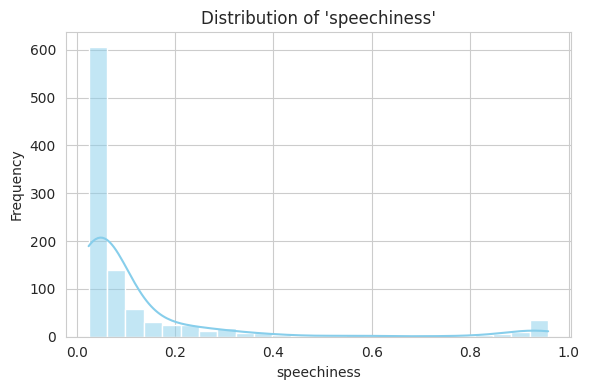

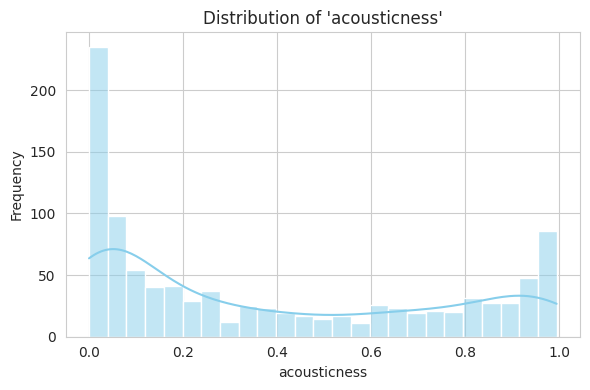

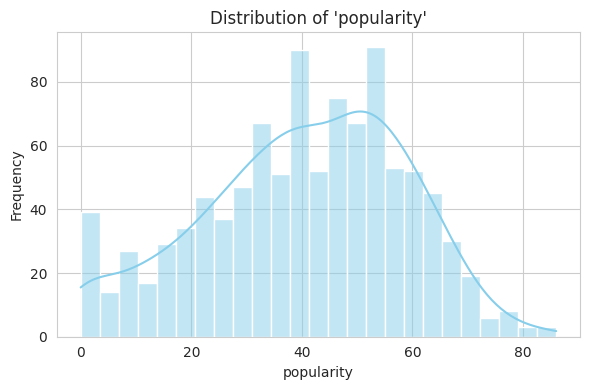

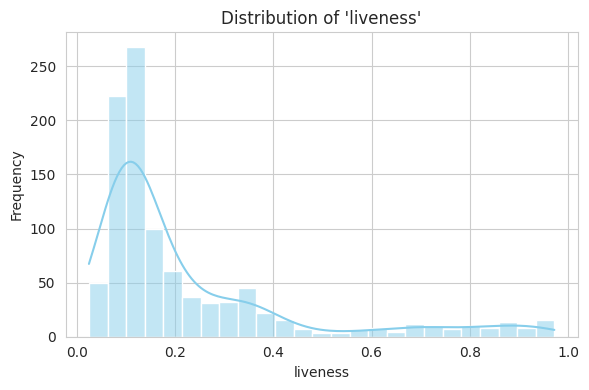

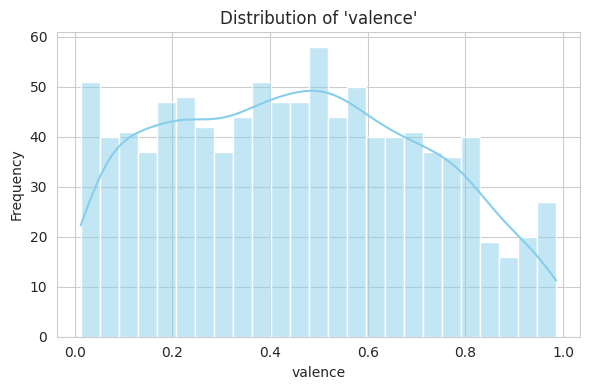

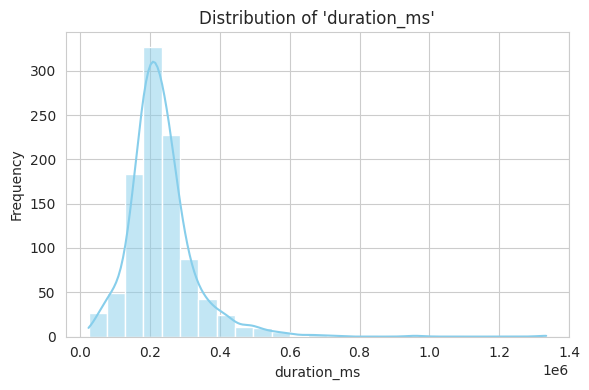

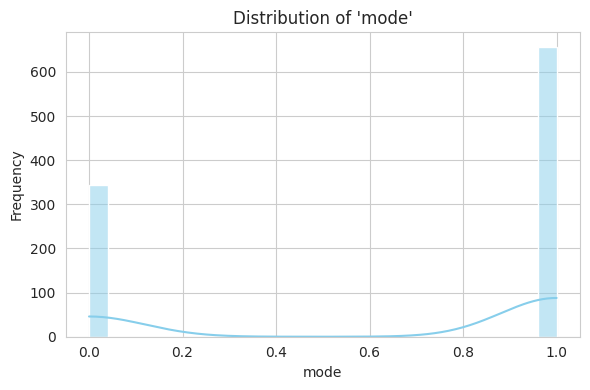

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


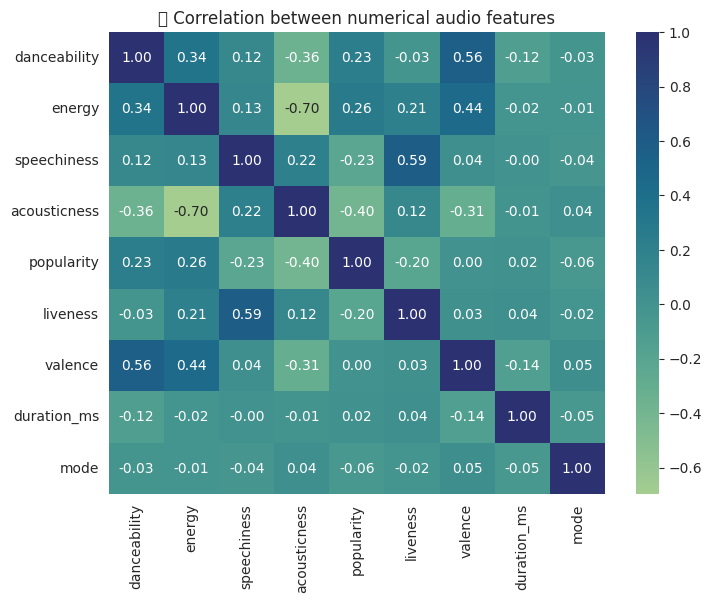

In [ ]:
# ---------------------------------------------
# 3b. Initial feature visualization
# ---------------------------------------------
sns.set_style("whitegrid")
sns.set_palette("Set2")

print("📊 Distribution of audio features before clustering:\n")

for col in features:
    plt.figure(figsize=(6,4))

    # If the column is categorical (e.g., genre)
    # Use df_sample for categorical features like 'genre'
    if col in categorical_features:
        sns.countplot(y=df_sample[col], order=df_sample[col].value_counts().index, palette="viridis", hue=df_sample[col], legend=False)
        plt.title(f"Distribution of '{col}' categories")
        plt.xlabel("Frequency")
        plt.ylabel(col)
        plt.tight_layout()

    # If the column is numerical (float or int)
    else:
        sns.histplot(X[col], kde=True, bins=25, color="skyblue")
        plt.title(f"Distribution of '{col}'")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()

    plt.show()

# ---------------------------------------------
#  Correlation between numerical features (Heatmap)
# ---------------------------------------------
# Consider only numerical features for correlation
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

if len(numeric_cols) > 1:
    plt.figure(figsize=(8,6))
    corr = X[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='crest', fmt=".2f")
    plt.title("🔗 Correlation between numerical audio features")
    plt.show()

/tmp/ipython-input-154300751.py:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


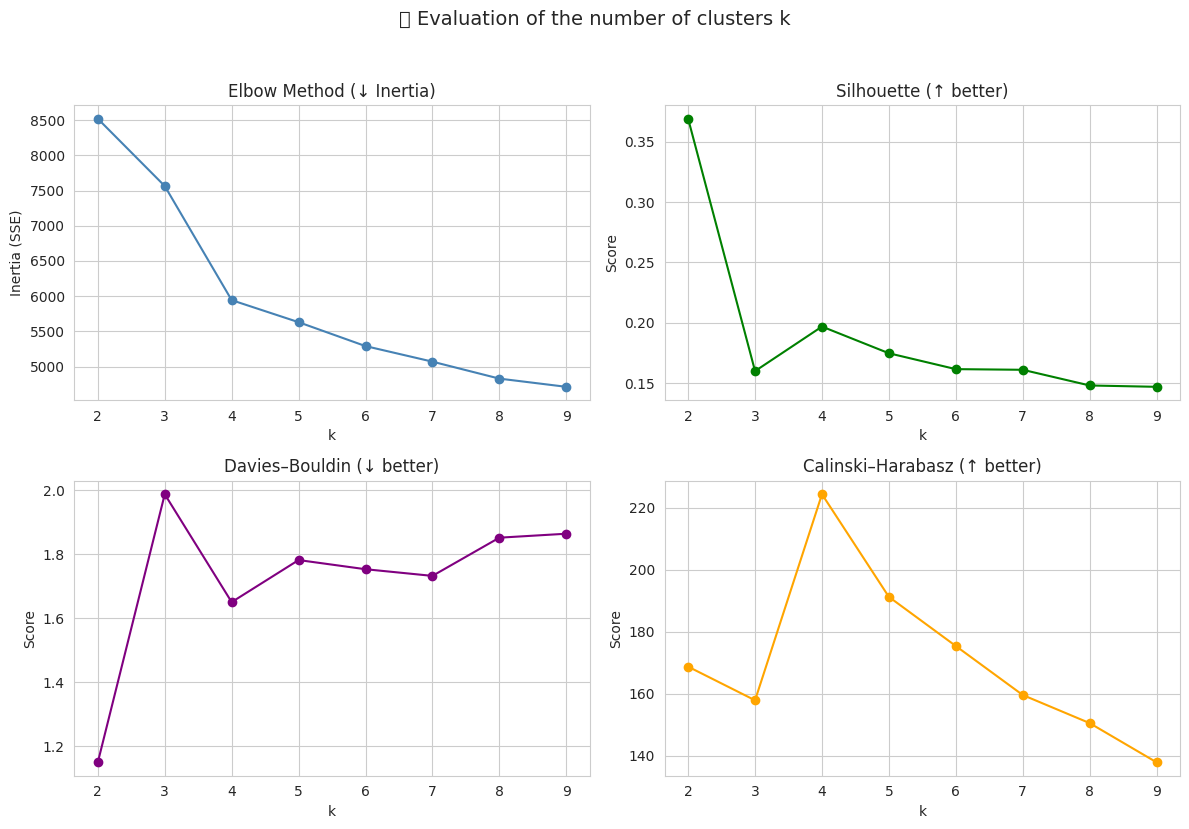

In [ ]:
# ---------------------------------------------
# Find the best number of clusters (k)
# ---------------------------------------------
K = range(2, 10)
inertias = []
silhouette_scores = []
db_scores = []
ch_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(X_scaled)

    # Evaluation metrics
    inertias.append(km.inertia_)  # sum of intra-cluster distances
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# ---------------------------------------------
# Comparative plots (including Elbow)
# ---------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Elbow Method
axs[0,0].plot(K, inertias, 'o-', color='steelblue')
axs[0,0].set_title("Elbow Method (↓ Inertia)")
axs[0,0].set_xlabel("k")
axs[0,0].set_ylabel("Inertia (SSE)")
axs[0,0].grid(True)

# Silhouette
axs[0,1].plot(K, silhouette_scores, 'o-', color='green')
axs[0,1].set_title("Silhouette (↑ better)")
axs[0,1].set_xlabel("k")
axs[0,1].set_ylabel("Score")
axs[0,1].grid(True)

# Davies–Bouldin
axs[1,0].plot(K, db_scores, 'o-', color='purple')
axs[1,0].set_title("Davies–Bouldin (↓ better)")
axs[1,0].set_xlabel("k")
axs[1,0].set_ylabel("Score")
axs[1,0].grid(True)

# Calinski–Harabasz
axs[1,1].plot(K, ch_scores, 'o-', color='orange')
axs[1,1].set_title("Calinski–Harabasz (↑ better)")
axs[1,1].set_xlabel("k")
axs[1,1].set_ylabel("Score")
axs[1,1].grid(True)

plt.suptitle("📊 Evaluation of the number of clusters k", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

⭐ Best k according to Elbow (Successive Differences): 6
⭐ Best k according to Elbow (Geometric Distance): 4


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


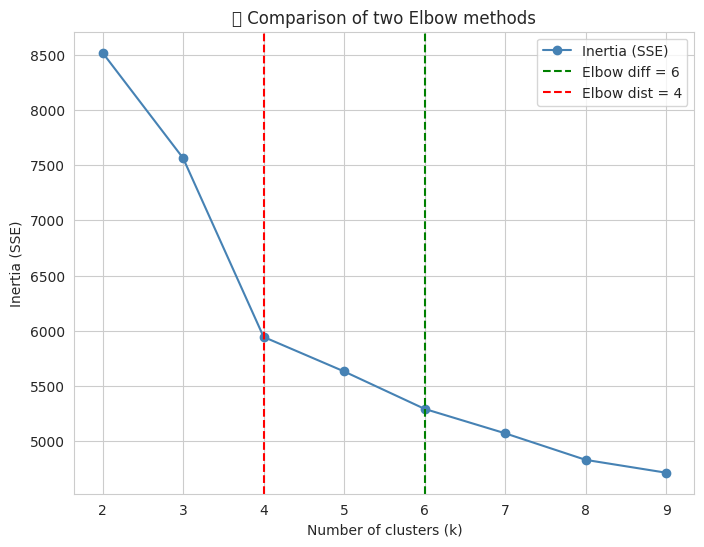

In [ ]:
# ---------------------------------------------
# 🔍 Comparison between two Elbow methods
# ---------------------------------------------
import math
import numpy as np

# Method 1: Successive differences
def elbow_diff_method(k_vals, inertias):
    diff_inertias = np.diff(inertias)
    ratios = np.abs(diff_inertias[1:] / diff_inertias[:-1])
    # the elbow is where the drop slows down (ratio close to 1)
    best_k = k_vals[np.argmin(np.abs(ratios - 1)) + 2]
    return best_k

# Method 2: Maximum distance from the line segment
def detect_elbow_distance(k_vals, inertias):
    p1x, p1y = k_vals[0], inertias[0]
    p2x, p2y = k_vals[-1], inertias[-1]
    dists = []
    for k, val in zip(k_vals, inertias):
        px, py = k, val
        num = abs((p2x - p1x) * (p1y - py) - (p2y - p1y) * (p1x - px))
        den = math.hypot(p2x - p1x, p2y - p1y)
        dists.append(num / den if den != 0 else 0.0)
    elbow_idx = int(np.argmax(dists))
    return int(k_vals[elbow_idx]), dists

# Calculate both
best_k_el_diff = elbow_diff_method(K, inertias)
best_k_el_dist, dists = detect_elbow_distance(K, inertias)

print(f"⭐ Best k according to Elbow (Successive Differences): {best_k_el_diff}")
print(f"⭐ Best k according to Elbow (Geometric Distance): {best_k_el_dist}")

# ---------------------------------------------
# 🔹 Comparative visualization
# ---------------------------------------------
plt.figure(figsize=(8,6))
plt.plot(K, inertias, 'o-', color='steelblue', label='Inertia (SSE)')
plt.axvline(best_k_el_diff, color='green', linestyle='--', label=f"Elbow diff = {best_k_el_diff}")
plt.axvline(best_k_el_dist, color='red', linestyle='--', label=f"Elbow dist = {best_k_el_dist}")
plt.title("📉 Comparison of two Elbow methods")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.legend()
plt.grid(True)
plt.show()

# # (Optional) Also show the distance curve for method 2
# plt.figure(figsize=(7,4))
# plt.plot(K, dists, 'o-', color='darkorange')
# plt.title("📏 Perpendicular distance from the segment (geometric method)")
# plt.xlabel("k")
# plt.ylabel("Distance from the line segment")
# plt.grid(True)
# plt.show()

In [ ]:
# ---------------------------------------------
# Automatic selection of the best k (including two Elbow methods)
# ---------------------------------------------
from collections import Counter
import numpy as np
import math

# Function 1 - Elbow based on successive differences
def elbow_diff_method(k_vals, inertias):
    diff_inertias = np.diff(inertias)
    ratios = np.abs(diff_inertias[1:] / diff_inertias[:-1])
    # the elbow is where the drop slows down (ratio close to 1)
    best_k = k_vals[np.argmin(np.abs(ratios - 1)) + 2]
    return best_k

# Function 2 - Elbow based on maximum distance from the line segment
def detect_elbow_distance(k_vals, inertias):
    p1x, p1y = k_vals[0], inertias[0]
    p2x, p2y = k_vals[-1], inertias[-1]
    dists = []
    for k, val in zip(k_vals, inertias):
        px, py = k, val
        num = abs((p2x - p1x) * (p1y - py) - (p2y - p1y) * (p1x - px))
        den = math.hypot(p2x - p1x, p2y - p1y)
        dists.append(num / den if den != 0 else 0.0)
    elbow_idx = int(np.argmax(dists))
    return int(k_vals[elbow_idx]), dists

# Calculate the best values for each method
best_k_sil = K[np.argmax(silhouette_scores)]
best_k_db = K[np.argmin(db_scores)]
best_k_ch = K[np.argmax(ch_scores)]
best_k_el_diff = elbow_diff_method(K, inertias)
best_k_el_dist, dists = detect_elbow_distance(K, inertias)

# Print the results
print("⭐ Best k according to each metric:")
print(f"  - Silhouette:           {best_k_sil}")
print(f"  - Davies–Bouldin:       {best_k_db}")
print(f"  - Calinski–Harabasz:    {best_k_ch}")
print(f"  - Elbow (Differences):   {best_k_el_diff}")
print(f"  - Elbow (Distance):     {best_k_el_dist}")

# Final choice by majority
best_overall = Counter([
    best_k_sil, best_k_db, best_k_ch, best_k_el_diff, best_k_el_dist
]).most_common(1)[0][0]

print(f"\n👉 Final k automatically chosen: {best_overall}")

# ---------------------------------------------
# Final clustering with the best k
# ---------------------------------------------
km = KMeans(n_clusters=best_overall, random_state=0)
X['cluster'] = km.fit_predict(X_scaled)

⭐ Best k according to each metric:
  - Silhouette:           2
  - Davies–Bouldin:       2
  - Calinski–Harabasz:    4
  - Elbow (Differences):   6
  - Elbow (Distance):     4

👉 Final k automatically chosen: 2


In [ ]:
# ---------------------------------------------
# 4. Summary statistics and tests for k=2 and k=3
# ---------------------------------------------
import pandas as pd
from scipy import stats
import statsmodels.stats.multitest as smm

# Function to perform clustering and statistical analysis
def analyze_k(k_val):
    print(f"\n{'='*60}\n🔹 ANALYSIS FOR k = {k_val}\n{'='*60}")

    # Perform clustering
    km = KMeans(n_clusters=k_val, random_state=0)
    X[f'cluster_{k_val}'] = km.fit_predict(X_scaled)

    # Consider only numerical columns
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

    # Summary (mean and standard deviation)
    summary = X.groupby(f'cluster_{k_val}')[numeric_cols].agg(['mean', 'std'])
    print("📊 MEAN and STANDARD DEVIATION per cluster:\n")
    display(summary.round(3))

    # Kruskal-Wallis test
    pvals = {}
    for col in numeric_cols:
        groups = [X.loc[X[f'cluster_{k_val}'] == c, col] for c in X[f'cluster_{k_val}'].unique()]
        pvals[col] = stats.kruskal(*groups).pvalue

    # FDR correction
    _, pvals_fdr, _, _ = smm.multipletests(list(pvals.values()), method='fdr_bh')
    pvals_corr = dict(zip(numeric_cols, pvals_fdr))

    # Sorted table of p-values
    pvals_df = (
        pd.DataFrame.from_dict(pvals_corr, orient='index', columns=['p-value_FDR'])
        .sort_values('p-value_FDR')
        .round(4)
    )
    print("\n📈 SIGNIFICANCE TEST (Kruskal-Wallis with FDR correction):\n")
    display(pvals_df)

    # Automatic interpretation
    print("\n🧠 AUTOMATIC INTERPRETATION:")
    for col, p in pvals_corr.items():
        if p < 0.001:
            level = "highly significant"
        elif p < 0.01:
            level = "significant"
        elif p < 0.05:
            level = "weakly significant"
        else:
            level = "not significant"
        print(f"- {col}: differences between clusters are {level} (p = {p:.4f})")

    # (Optional) Chi-square test for 'genre' if present
    if 'genre' in X.columns:
        contingency = pd.crosstab(X['genre'], X[f'cluster_{k_val}'])
        chi2, p, dof, ex = stats.chi2_contingency(contingency, correction=False)
        print(f"\n📊 Chi-square test for 'genre': p = {p:.4f}")

# ---------------------------------------------
# Run for k=2 and k=3
# ---------------------------------------------
analyze_k(2)
analyze_k(3)


🔹 ANALYSIS FOR k = 2
📊 MEAN and STANDARD DEVIATION per cluster:



danceability       energy        speechiness        acousticness  \
                  mean   std   mean    std        mean    std         mean   
cluster_2                                                                    
0                0.555  0.11  0.617  0.235       0.833  0.211        0.774   
1                0.554  0.19  0.558  0.264       0.080  0.082        0.350   

                 popularity         liveness        valence         \
             std       mean     std     mean    std    mean    std   
cluster_2                                                            
0          0.198     18.672  10.463    0.744  0.244   0.430  0.200   
1          0.351     41.894  17.835    0.187  0.158   0.458  0.263   

          duration_ms               mode         
                 mean         std   mean    std  
cluster_2                                        
0          239588.746  184350.073  0.687  0.467  
1          231690.163   89381.467  0.655  0.476


📈 SIGNIFICANCE TEST (Kruskal-Wallis with FDR correction):



,p-value_FDR
speechiness,0.0000
liveness,0.0000
popularity,0.0000
acousticness,0.0000
energy,0.1801
duration_ms,0.2153
valence,0.6340
danceability,0.6403
mode,0.6403



🧠 AUTOMATIC INTERPRETATION:
- danceability: differences between clusters are not significant (p = 0.6403)
- energy: differences between clusters are not significant (p = 0.1801)
- speechiness: differences between clusters are highly significant (p = 0.0000)
- acousticness: differences between clusters are highly significant (p = 0.0000)
- popularity: differences between clusters are highly significant (p = 0.0000)
- liveness: differences between clusters are highly significant (p = 0.0000)
- valence: differences between clusters are not significant (p = 0.6340)
- duration_ms: differences between clusters are not significant (p = 0.2153)
- mode: differences between clusters are not significant (p = 0.6403)

🔹 ANALYSIS FOR k = 3
📊 MEAN and STANDARD DEVIATION per cluster:



danceability        energy        speechiness        acousticness  \
                  mean    std   mean    std        mean    std         mean   
cluster_3                                                                     
0                0.561  0.104  0.635  0.224       0.885  0.133        0.808   
1                0.561  0.200  0.562  0.261       0.093  0.101        0.330   
2                0.550  0.183  0.555  0.266       0.077  0.080        0.363   

                 popularity         liveness        valence         \
             std       mean     std     mean    std    mean    std   
cluster_3                                                            
0          0.104     18.983   8.919    0.763  0.216   0.427  0.204   
1          0.340     43.251  17.523    0.196  0.172   0.438  0.261   
2          0.358     40.890  18.177    0.187  0.161   0.469  0.263   

          duration_ms               mode         
                 mean         std   mean    std  
cluster_3                                        
0          246041.417  192003.739  0.667  0.475  
1          237350.272   92189.438  0.000  0.000  
2          228189.214   87821.822  1.000  0.000


📈 SIGNIFICANCE TEST (Kruskal-Wallis with FDR correction):



,p-value_FDR
mode,0.0000
speechiness,0.0000
liveness,0.0000
popularity,0.0000
acousticness,0.0000
energy,0.1631
valence,0.2530
duration_ms,0.3727
danceability,0.4387



🧠 AUTOMATIC INTERPRETATION:
- danceability: differences between clusters are not significant (p = 0.4387)
- energy: differences between clusters are not significant (p = 0.1631)
- speechiness: differences between clusters are highly significant (p = 0.0000)
- acousticness: differences between clusters are highly significant (p = 0.0000)
- popularity: differences between clusters are highly significant (p = 0.0000)
- liveness: differences between clusters are highly significant (p = 0.0000)
- valence: differences between clusters are not significant (p = 0.2530)
- duration_ms: differences between clusters are not significant (p = 0.3727)
- mode: differences between clusters are highly significant (p = 0.0000)



🌲 RANDOM FOREST - k = 2

🎯 Permutation Importances (mean):


,0
speechiness,0.0748
liveness,0.0056
popularity,0.0047
genre_Reggae,0.0010
acousticness,0.0000
energy,0.0000
danceability,0.0000
valence,0.0000
mode,0.0000
genre_A Capella,0.0000



🌲 RANDOM FOREST - k = 3

🎯 Permutation Importances (mean):


,0
mode,0.4197
speechiness,0.0527
liveness,0.0019
acousticness,0.0009
genre_Comedy,0.0008
popularity,0.0008
valence,0.0008
danceability,0.0003
energy,0.0000
duration_ms,0.0000


/tmp/ipython-input-404591367.py:62: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


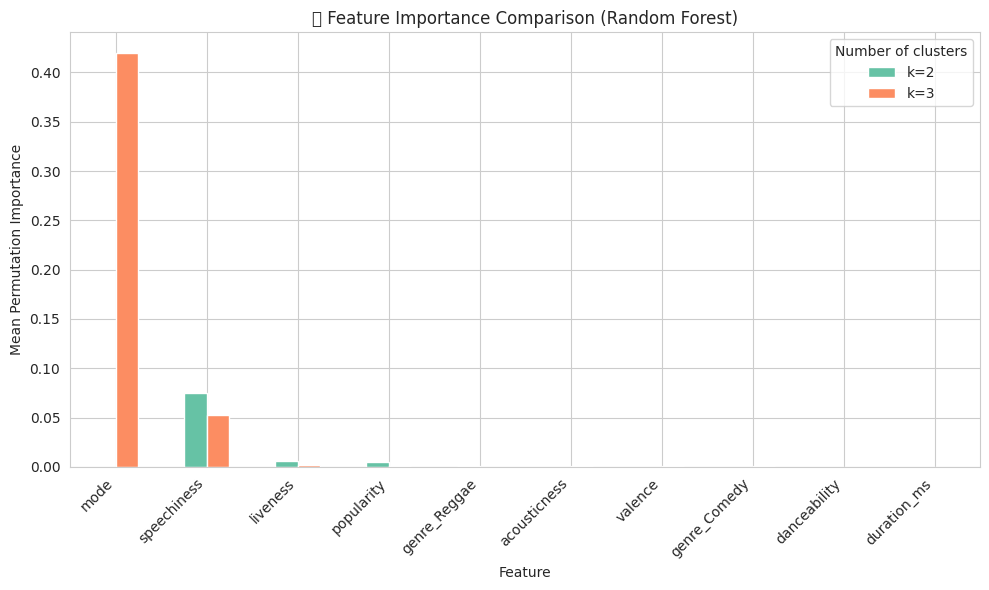

In [ ]:
# ---------------------------------------------
# 5. Random Forest importance for k=2 and k=3 (with one-hot encoding)
# ---------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

def rf_importance_for_k(k_val):
    print(f"\n{'='*60}\n🌲 RANDOM FOREST - k = {k_val}\n{'='*60}")

    # Clustering
    km = KMeans(n_clusters=k_val, random_state=0)
    clusters = km.fit_predict(X_scaled) # X_scaled contains all the features (numeric scaled + binary + one-hot encoded)

    # X_scaled already contains all features needed for the RF model
    # We need the column names corresponding to X_scaled
    feature_names = X_final.columns.tolist()

    # Create a DataFrame with the scaled data and correct column names
    X_full = pd.DataFrame(X_scaled, columns=feature_names)
    X_full[f'cluster_{k_val}'] = clusters

    # Feature + target
    X_feats = X_full.drop(columns=[f'cluster_{k_val}'])
    y = X_full[f'cluster_{k_val}']

    # Train the Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=0)
    rf.fit(X_feats, y)

    # Calculate permutation importances
    perm = permutation_importance(rf, X_feats, y, n_repeats=10, random_state=0)
    importances = pd.Series(perm.importances_mean, index=X_feats.columns).sort_values(ascending=False)

    print("\n🎯 Permutation Importances (mean):")
    display(importances.head(10))

    return importances

# Calculate importances for k=2 and k=3
importances_k2 = rf_importance_for_k(2)
importances_k3 = rf_importance_for_k(3)

# ---------------------------------------------
# 🔹 Comparative visualization
# ---------------------------------------------
imp_compare = pd.DataFrame({
    'k=2': importances_k2,
    'k=3': importances_k3
}).fillna(0)

top_feats = imp_compare.sum(axis=1).sort_values(ascending=False).head(10).index
imp_top = imp_compare.loc[top_feats]

imp_top.plot(kind='bar', figsize=(10,6))
plt.title("🎵 Feature Importance Comparison (Random Forest)")
plt.ylabel("Mean Permutation Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Number of clusters")
plt.tight_layout()
plt.show()


📊 Scatter plots for k = 2
Most relevant features for visualization (k=2): ['speechiness', 'liveness', 'popularity']


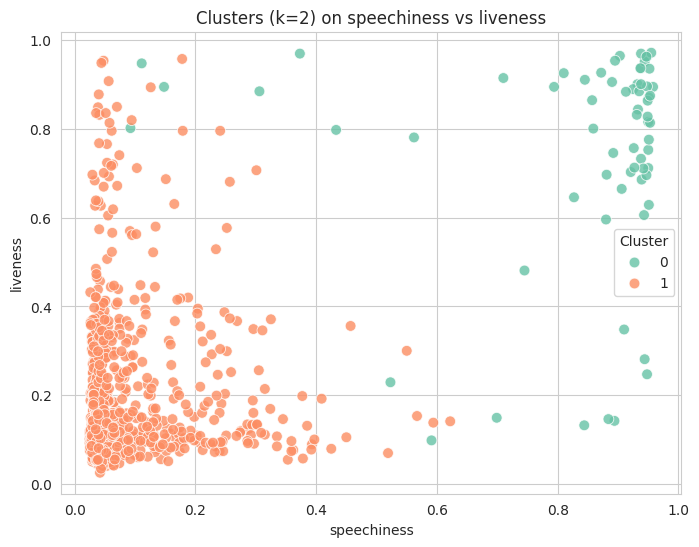


📊 Scatter plots for k = 3
Most relevant features for visualization (k=3): ['mode', 'speechiness', 'liveness']


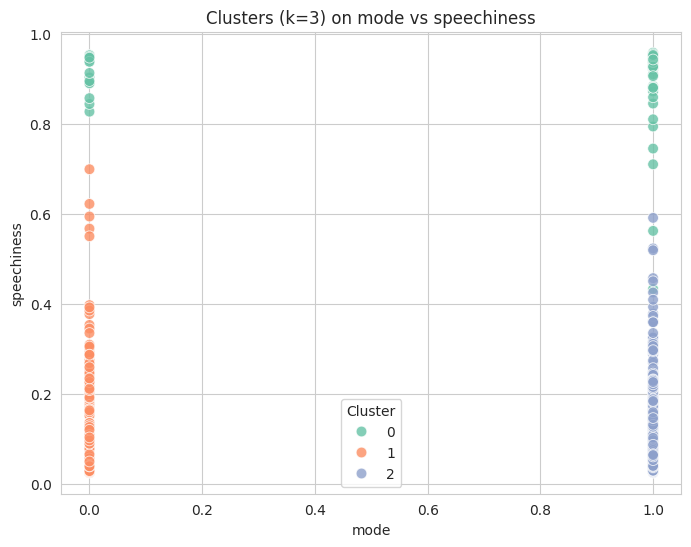

In [ ]:
# ---------------------------------------------
# 6. Scatter plots for the most relevant features
# ---------------------------------------------

# Re-run clustering for k=2 and k=3 to make 'cluster_2' and 'cluster_3' available
km_k2 = KMeans(n_clusters=2, random_state=0)
X['cluster_2'] = km_k2.fit_predict(X_scaled)

km_k3 = KMeans(n_clusters=3, random_state=0)
X['cluster_3'] = km_k3.fit_predict(X_scaled)


# Function to generate scatter plots for a given k
def plot_clusters(k_val, importances, X_data):
    print(f"\n📊 Scatter plots for k = {k_val}")
    top_features = importances.head(3).index.tolist()  # take the 3 most important
    print(f"Most relevant features for visualization (k={k_val}):", top_features)

    if len(top_features) < 2:
        print(f"Not enough relevant features for k={k_val} to create a scatter plot.")
        return

    # 1️⃣ Scatter plot of the top two most important features
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_data[top_features[0]],
        y=X_data[top_features[1]],
        hue=X_data[f'cluster_{k_val}'],
        palette='Set2',
        s=60,
        alpha=0.8
    )
    plt.title(f"Clusters (k={k_val}) on {top_features[0]} vs {top_features[1]}")
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1])
    plt.legend(title='Cluster')
    plt.show()

    # 2️⃣ If a third feature exists, use it as the point size
    # if len(top_features) >= 3:
    #     plt.figure(figsize=(8,6))
    #     scatter = plt.scatter(
    #         X_data[top_features[0]],
    #         X_data[top_features[1]],
    #         c=X_data[f'cluster_{k_val}'],
    #         cmap='Set2',
    #         s=100 * X_data[top_features[2]],  # the third feature modulates the size
    #         alpha=0.6,
    #         edgecolor='k'
    #     )
    #     plt.title(f"Clusters (k={k_val}) on {top_features[0]} vs {top_features[1]} (size={top_features[2]})")
    #     plt.xlabel(top_features[0])
    #     plt.ylabel(top_features[1])
    #     plt.colorbar(scatter, label="Cluster")
    #     plt.show()


# Plot for k=2
plot_clusters(2, importances_k2, X)

# Plot for k=3
plot_clusters(3, importances_k3, X)


📊 VISUALIZATIONS FOR k = 2


/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


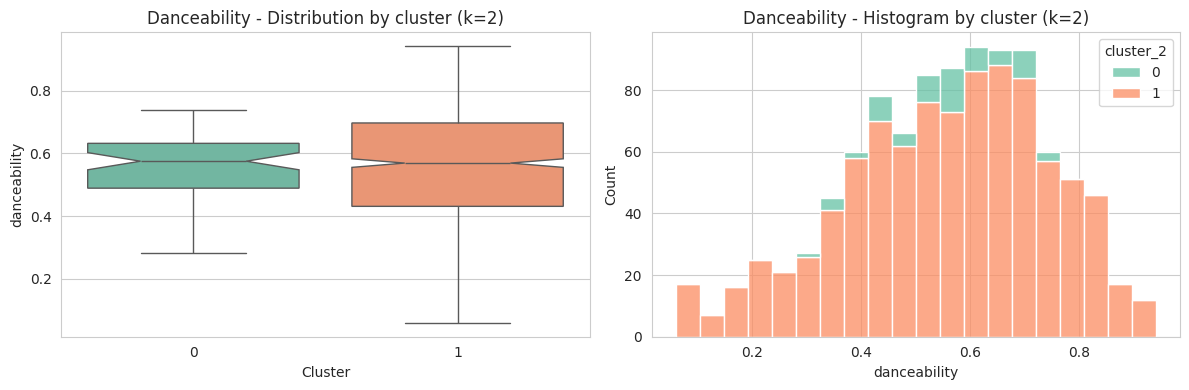

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


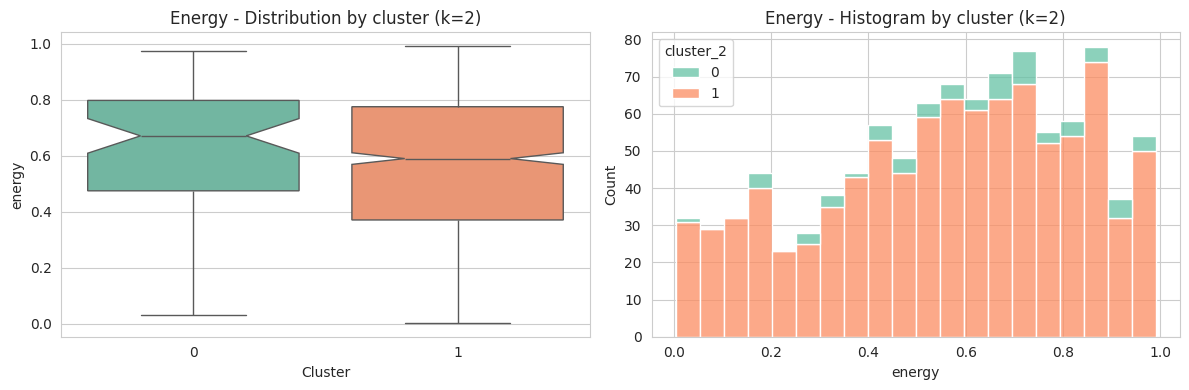

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


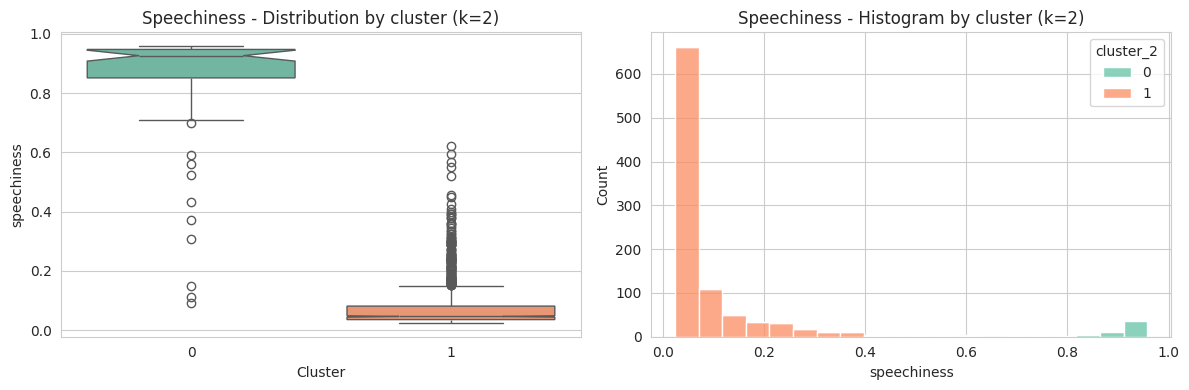

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


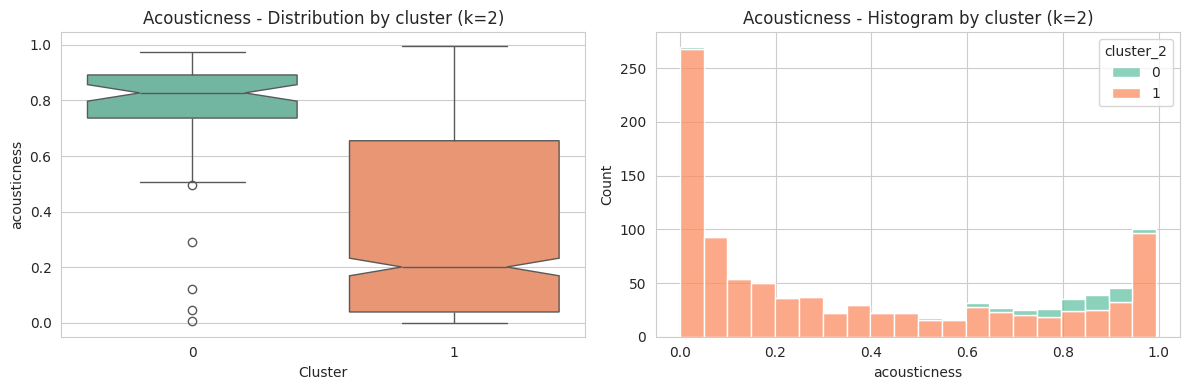

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


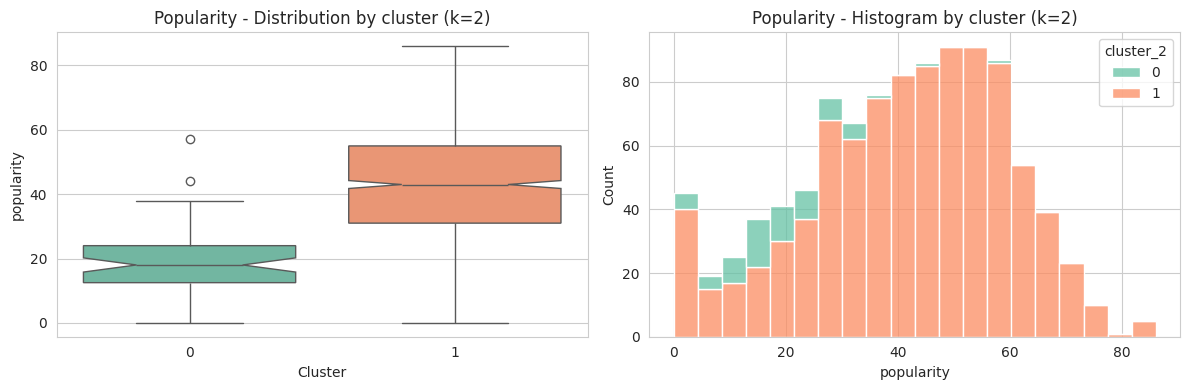

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


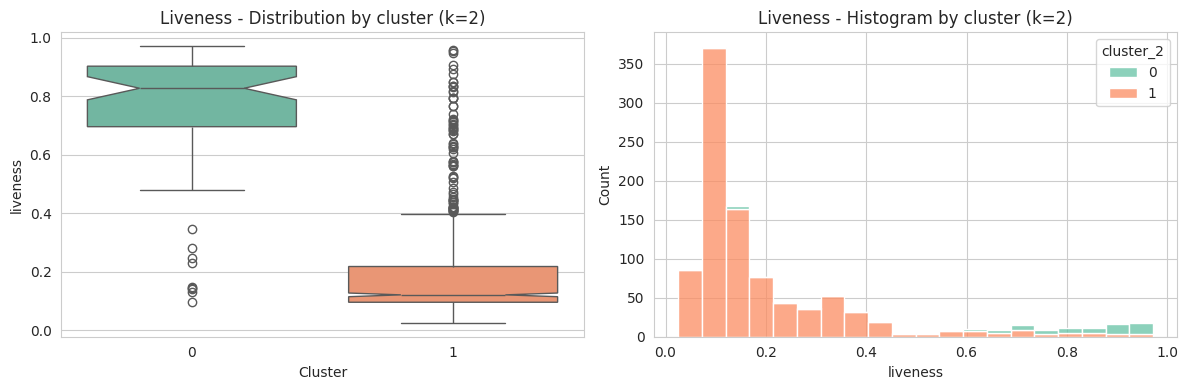

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


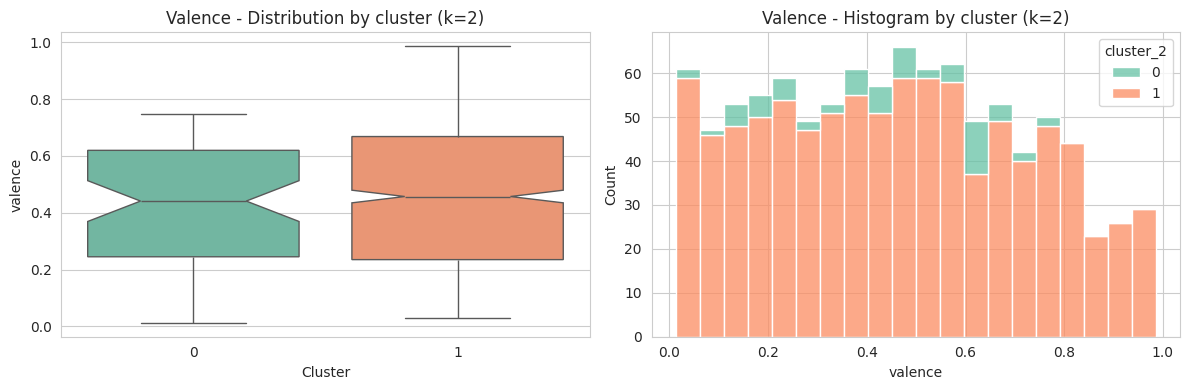

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


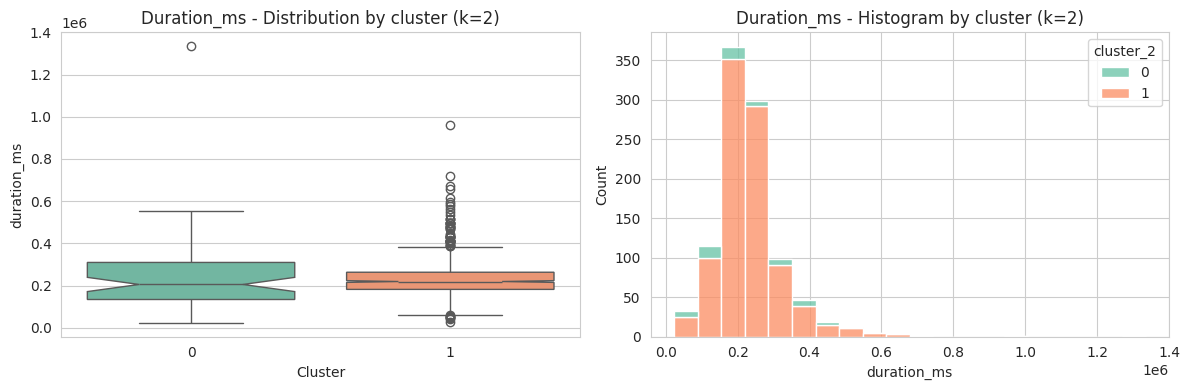


📊 VISUALIZATIONS FOR k = 3


/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


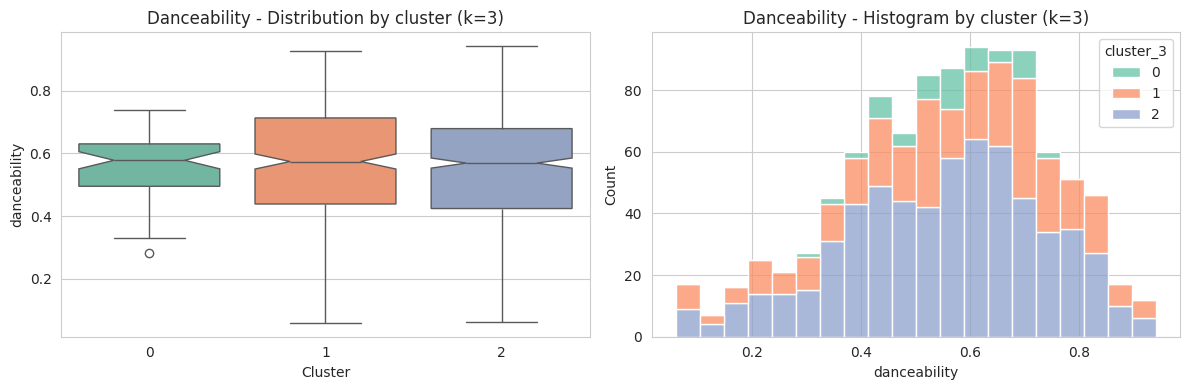

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


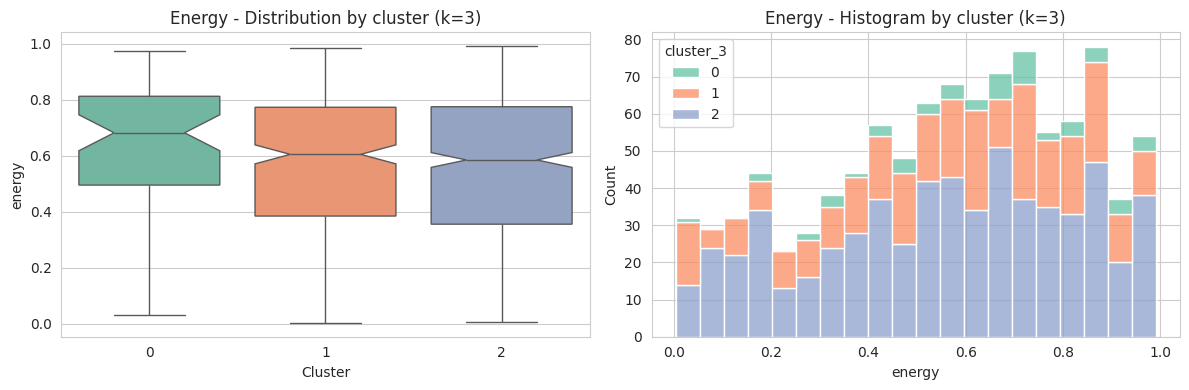

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


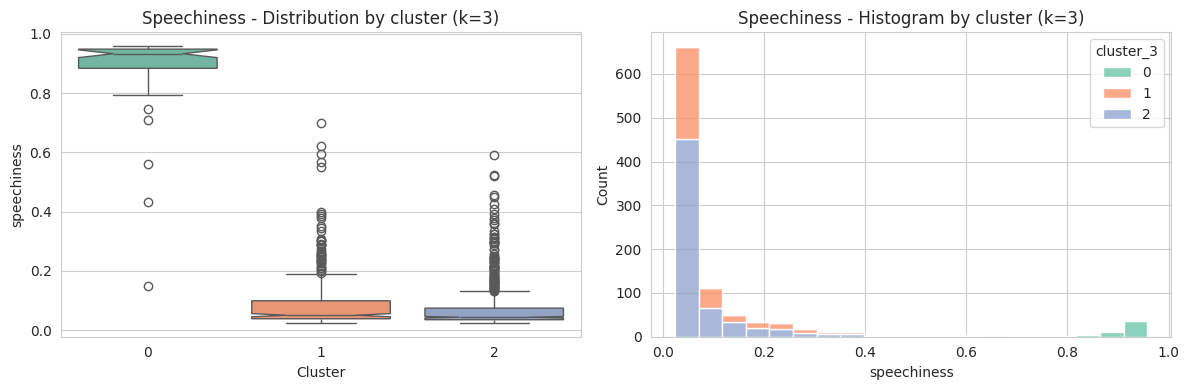

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


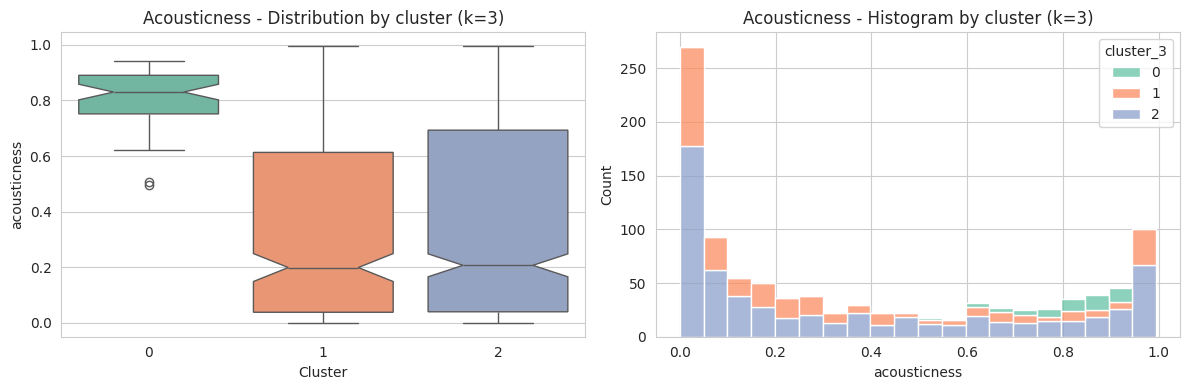

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


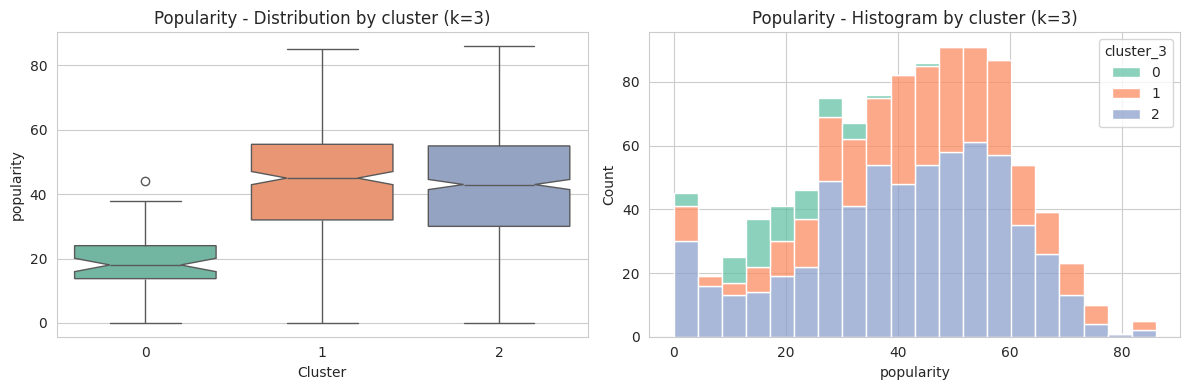

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


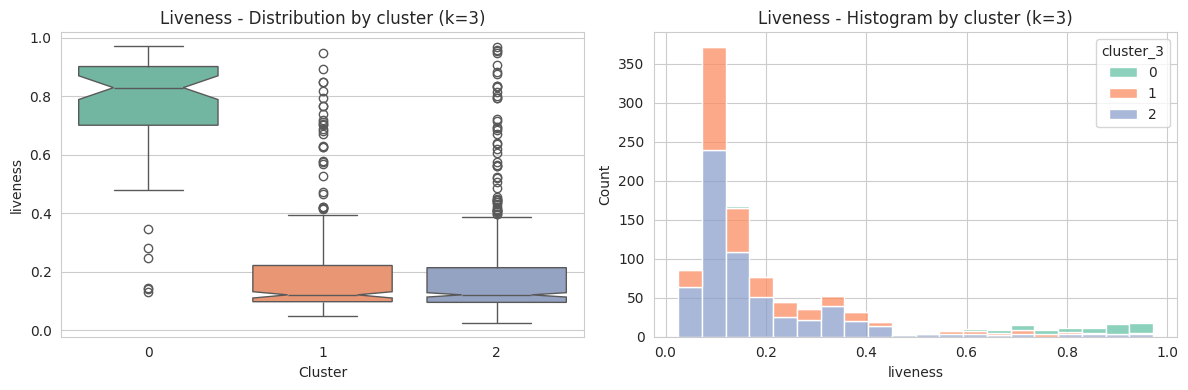

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


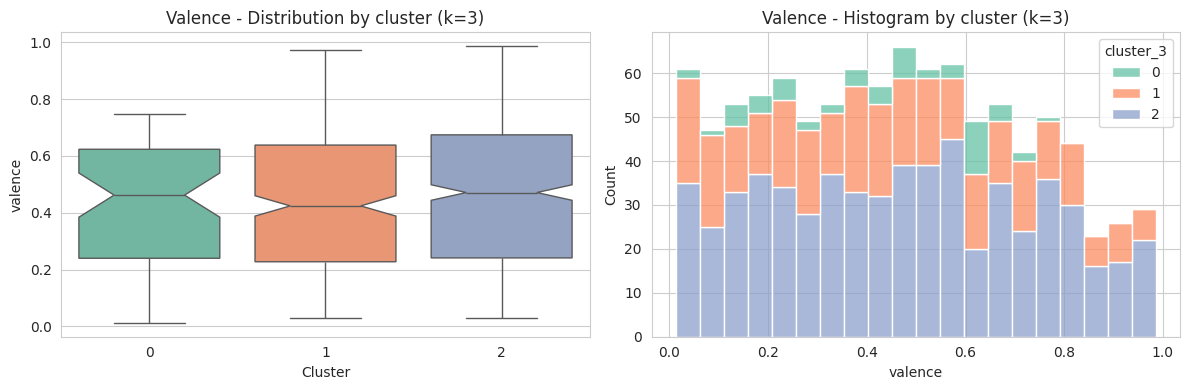

/tmp/ipython-input-3833499257.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)


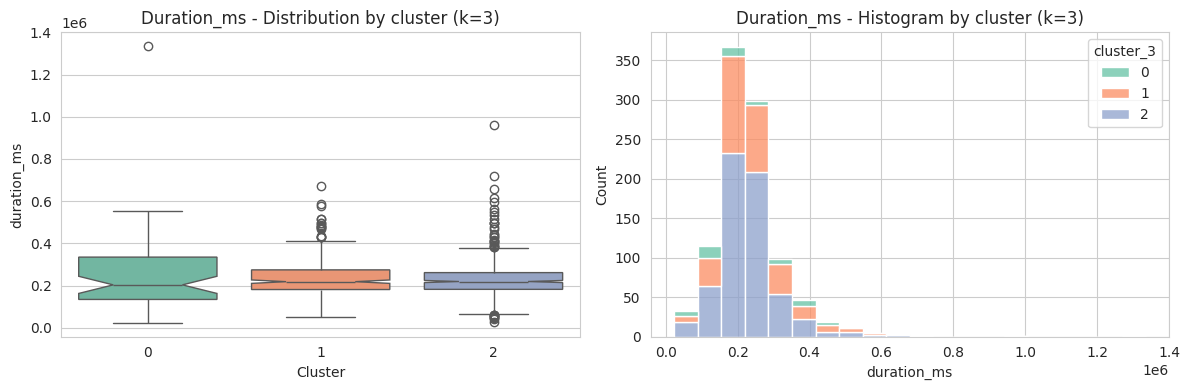

In [ ]:
# ---------------------------------------------
# 7. Visualizations
# ---------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_visualizations_for_k(k_val, X_data):
    print(f"\n{'='*60}\n📊 VISUALIZATIONS FOR k = {k_val}\n{'='*60}")

    # Define the numeric columns to visualize (excluding 'mode' for these plots)
    numeric_cols_to_plot = [
        'danceability', 'energy', 'speechiness', 'acousticness',
        'popularity', 'liveness', 'valence', 'duration_ms'
    ]

    # Boxplot + Histograms for each numeric feature
    for col in numeric_cols_to_plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Create a subset of data for plotting by explicitly selecting columns from the original X
        plot_data = X[[col, f'cluster_{k_val}']].copy()

        # --- Debugging Step: Check dtypes and drop object columns if any ---
        if plot_data.select_dtypes(include='object').empty is False:
            print(f"DEBUG: Object columns found in plot_data for column '{col}': {plot_data.select_dtypes(include='object').columns.tolist()}")
            # Drop any object columns found (should not happen if data prep is correct, but as a failsafe)
            plot_data = plot_data.select_dtypes(exclude='object')
            print(f"DEBUG: Object columns after dropping: {plot_data.select_dtypes(include='object').columns.tolist()}")
        # --- End Debugging Step ---


        # Boxplot by cluster
        sns.boxplot(x=f'cluster_{k_val}', y=col, data=plot_data, ax=axes[0], palette='Set2', notch=True)
        axes[0].set_title(f"{col.capitalize()} - Distribution by cluster (k={k_val})")
        axes[0].set_xlabel("Cluster")
        axes[0].set_ylabel(col)

        # Histogram by cluster
        sns.histplot(data=plot_data, x=col, hue=f'cluster_{k_val}', multiple='stack', bins=20, ax=axes[1], palette='Set2')
        axes[1].set_title(f"{col.capitalize()} - Histogram by cluster (k={k_val})")
        axes[1].set_xlabel(col)
        axes[1].set_ylabel("Count")

        plt.tight_layout()
        plt.show()

# Plot visualizations for k=2
plot_visualizations_for_k(2, X)

# Plot visualizations for k=3
plot_visualizations_for_k(3, X)

In [ ]:
# ---------------------------------------------
# 8. Sankey Diagram (k=2 vs k=3)
# ---------------------------------------------
import plotly.graph_objects as go
import plotly.colors

# Make sure the cluster columns are present in the X DataFrame
# If not present, re-run the previous cells to create them
if 'cluster_2' not in X.columns or 'cluster_3' not in X.columns:
    print("Columns 'cluster_2' or 'cluster_3' are not present in X. Please re-run cells 4 and 5.")
else:
    # Prepare data for the Sankey diagram
    # Create a count of transitions from cluster_2 to cluster_3
    sankey_data = X.groupby(['cluster_2', 'cluster_3']).size().reset_index(name='count')

    # Define nodes (clusters for k=2 and k=3)
    # k=2 nodes will be source nodes, k=3 nodes will be target nodes
    labels = [f'k=2 - Cluster {c}' for c in sorted(X['cluster_2'].unique())] + \
             [f'k=3 - Cluster {c}' for c in sorted(X['cluster_3'].unique())]

    # Generate a list of colors for the nodes
    # Use a Plotly color palette, ensuring enough colors
    num_nodes = len(labels)
    node_colors = plotly.colors.qualitative.Set3[:num_nodes] # Use a qualitative palette

    # Create indices for source and target nodes
    # source: index of the source node (k=2 cluster)
    # target: index of the target node (k=3 cluster)
    # value: count of tracks in the transition
    source_indices = [sorted(X['cluster_2'].unique()).index(row['cluster_2']) for index, row in sankey_data.iterrows()]
    target_indices = [len(X['cluster_2'].unique()) + sorted(X['cluster_3'].unique()).index(row['cluster_3']) for index, row in sankey_data.iterrows()]
    values = sankey_data['count'].tolist()

    # Generate a list of colors for the links
    # We can color the links based on the source node (k=2 cluster)
    link_colors = [node_colors[source_indices[i]].replace('rgb', 'rgba').replace(')', ', 0.7)') for i in range(len(source_indices))] # Make the links slightly transparent

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors # Assign colors to nodes
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values,
            color=link_colors # Assign colors to links
        )
    )])

    fig.update_layout(title_text="Sankey Diagram: Track Flow between k=2 and k=3 Clusters", font_size=10)
    fig.show()